In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Data Preprocessing

In [3]:
df = pd.read_csv('ml-latest-small/ratings.csv', usecols=[0, 1, 2])

In [4]:
# Preprocessing 
le = preprocessing.LabelEncoder()
le.fit(df['movieId'])
df['movieId'] = le.transform(df['movieId'])
le.fit(df['userId'])
df['userId'] = le.transform(df['userId'])
# df['rating'] = df['rating'] - np.mean(df['rating'])

In [6]:
df

,userId,movieId,rating
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0
...,...,...,...
100831,609,9416,4.0
100832,609,9443,5.0
100833,609,9444,5.0
100834,609,9445,5.0


In [7]:
X = df.drop(['rating'], axis=1).to_numpy()
y = df['rating'].to_numpy()

### Splitting the dataset into 80% train and 20% test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Converting the Train Dataset into a matrix

In [9]:
G = np.zeros((len(np.unique(df['userId'])), len(np.unique(df['movieId']))))

In [10]:
for i in tqdm(range(X_train.shape[0])):
    G[X_train[i][0], X_train[i][1]] = y_train[i]

100%|██████████| 80668/80668 [00:00<00:00, 436253.65it/s]


### k rank approximation using SVD

In [11]:
def k_rank_approximation(G, k):
    # We use full_matrices = False as it doesn't add any information
    u, s, vh = np.linalg.svd(G, full_matrices=False)
    u = u[:, :k]
    s = np.diag(s[:k])
    vh = vh[:k, :]
    return np.dot(np.dot(u, s), vh)

In [12]:
k_rank_approximation(G, 5)

array([[ 2.08293609e+00,  1.01204486e+00,  7.38387643e-01, ...,
        -5.17069199e-03, -5.17069199e-03, -1.58884608e-02],
       [ 1.94946765e-01,  6.71051717e-02, -8.59361796e-02, ...,
         2.55334371e-03,  2.55334371e-03,  7.18846198e-03],
       [ 7.56864940e-03,  2.07320184e-03,  2.77524775e-02, ...,
         8.11558902e-05,  8.11558902e-05, -1.06974281e-03],
       ...,
       [ 3.42588298e+00,  2.40084876e+00,  1.32722176e+00, ...,
         4.22840356e-03,  4.22840356e-03, -9.86585797e-04],
       [ 8.53412960e-01,  5.44126956e-01,  2.31502216e-01, ...,
        -3.32689993e-03, -3.32689993e-03, -3.90876641e-03],
       [ 1.87718036e+00,  1.24257909e+00,  1.99187545e-01, ...,
         4.52936079e-02,  4.52936079e-02,  6.23824764e-02]])

### k rank approximation predictions over the test set 

In [13]:
k_rank_error = {}
for i in tqdm(range(101)):
    err = 0
    k_rank_G = k_rank_approximation(G, i)
    for j in range(X_test.shape[0]):
        err += (k_rank_G[X_test[j][0], X_test[j][1]] - y_test[j])**2
    k_rank_error[i] = err


100%|██████████| 101/101 [02:47<00:00,  1.66s/it]


In [14]:
user_mean = np.mean(G, axis=1)
movie_mean = np.mean(G, axis=0)

### Linear Regression using user's mean rating and movie's mean rating

In [15]:
X_train_mod = np.zeros(X_train.shape)

In [16]:
X_train_mod[:, 0] = user_mean[X_train[:, 0]]
X_train_mod[:, 1] = movie_mean[X_train[:, 1]]

In [17]:
X_train_mod

array([[0.12412587, 0.07622951],
       [0.05234471, 0.02786885],
       [0.13420403, 0.48770492],
       ...,
       [0.22567873, 0.05737705],
       [0.0877211 , 0.00983607],
       [0.12104072, 0.36967213]])

In [18]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train_mod, y_train)
X_test_mod = np.zeros(X_test.shape)
X_test_mod[:, 0] = user_mean[X_test[:, 0]]
X_test_mod[:, 1] = movie_mean[X_test[:, 1]]
y_hat = model.predict(X_test_mod)
error = np.dot((y_hat - y_test), (y_hat - y_test))

In [19]:
error

91615.28567722077

Text(0.5, 1.0, 'relative average error vs k')

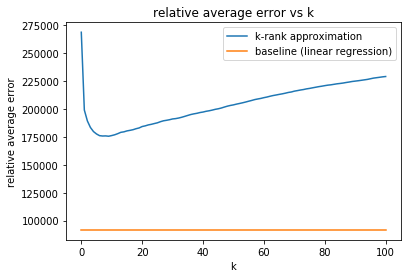

In [20]:
plt.plot(range(101), list(k_rank_error.values()), label='k-rank approximation')
plt.plot(range(101), [error]*101, label='baseline (linear regression)')
plt.legend()
plt.xlabel('k')
plt.ylabel('relative average error')
plt.title('relative average error vs k')